# Лабораторная работа: Интерполяция функций

Автор: Пан Владимир Олегович
Группа: 24.Б81мм

## Цель
Исследовать точность интерполяции функции Рунге тремя методами: интерполяционным многочленом Лагранжа, кубическим эрмитовым сплайном и квадратным B-сплайном. Сравнить теоретические оценки погрешности с фактическими на тестовой сетке, визуализировать результаты, обсудить эффект Рунге.

## Теория
- Функция Рунге: $f(x)=\dfrac{1}{1+25x^2}$ на $[-1,1]$.
- Узлы: равномерные и (по необходимости) Чебышёва.
- Погрешности:
  - Теоретическая: априорные оценки по формулам соответствующих методов.
  - Фактическая: $\max\limits_{x\in G} |f(x)-\tilde f(x)|$ на плотной сетке $G$.

## План эксперимента
1. Задать $f(x)$ и наборы узлов $\{x_i\}$ при нескольких $n$ (например, $n\in\{6, 10, 20, 40\}$).
2. Построить: Лагранж, кубический Эрмитов сплайн, квадратный B-сплайн.
3. Для каждого метода и $n$ оценить теоретическую погрешность, вычислить фактическую на тестовой сетке, построить графики.
4. Сравнить, сделать выводы о влиянии эффекта Рунге и сглаживающих свойств сплайнов.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass

# Настройки
plt.rcParams['figure.figsize'] = (7, 4)
np.set_printoptions(precision=6, suppress=True)

# Функция Рунге и производные

def f(x):
    return 1.0 / (1.0 + 25.0 * x**2)

def f1(x):
    return -50.0 * x / (1.0 + 25.0 * x**2)**2

def f2(x):
    return (-50.0 * (1.0 + 25.0 * x**2)**2 + 2.0 * (1.0 + 25.0 * x**2) * (50.0 * x) * (50.0 * x) / (1.0 + 25.0 * x**2)) / (1.0 + 25.0 * x**2)**3

# Узлы

def uniform_nodes(a, b, n):
    return np.linspace(a, b, n)

def chebyshev_nodes(a, b, n):
    k = np.arange(n)
    t = (2*k + 1) / (2*n)
    return 0.5*(a+b) + 0.5*(b-a)*np.cos(np.pi * t)

# Сетка для ошибок
A, B = -1.0, 1.0
X_test = np.linspace(A, B, 2001)
Y_true = f(X_test)



In [2]:
# Лагранж (барицентрическая)

def barycentric_weights(x):
    x = np.asarray(x)
    n = x.size
    w = np.ones(n)
    for j in range(n):
        diff = x[j] - np.delete(x, j)
        w[j] = 1.0 / np.prod(diff)
    return w

def lagrange_eval(x_nodes, y_nodes, x_eval, w=None):
    x_nodes = np.asarray(x_nodes)
    y_nodes = np.asarray(y_nodes)
    xe = np.asarray(x_eval)
    if w is None:
        w = barycentric_weights(x_nodes)
    P = np.zeros_like(xe, dtype=float)
    for k, xv in enumerate(xe):
        diff = xv - x_nodes
        mask = np.isclose(diff, 0.0)
        if mask.any():
            P[k] = y_nodes[mask.argmax()]
            continue
        num = np.sum(w * y_nodes / diff)
        den = np.sum(w / diff)
        P[k] = num / den
    return P



In [3]:
# Эрмит (кубический)

@dataclass
class HermiteSpline:
    x: np.ndarray
    y: np.ndarray
    yp: np.ndarray

    def __post_init__(self):
        self.x = np.asarray(self.x)
        self.y = np.asarray(self.y)
        self.yp = np.asarray(self.yp)
        self.h = np.diff(self.x)

    def evaluate(self, xq):
        xq = np.asarray(xq)
        s = np.zeros_like(xq, dtype=float)
        # Интервал
        idx = np.searchsorted(self.x, xq, side='right') - 1
        idx = np.clip(idx, 0, len(self.x) - 2)
        x0 = self.x[idx]
        x1 = self.x[idx+1]
        h = x1 - x0
        t = (xq - x0) / h
        h00 = (1 + 2*t) * (1 - t)**2
        h10 = t * (1 - t)**2
        h01 = t**2 * (3 - 2*t)
        h11 = t**2 * (t - 1)
        s = h00 * self.y[idx] + h10 * h * self.yp[idx] + h01 * self.y[idx+1] + h11 * h * self.yp[idx+1]
        return s

# Построитель

def build_hermite(x_nodes):
    return HermiteSpline(x_nodes, f(x_nodes), f1(x_nodes))



In [4]:
# Квадратный B-сплайн (C1)

@dataclass
class QuadraticSpline:
    x: np.ndarray
    y: np.ndarray

    def __post_init__(self):
        self.x = np.asarray(self.x)
        self.y = np.asarray(self.y)
        n = len(self.x)
        m = n - 1
        h = np.diff(self.x)
        a = self.y[:-1].copy()
        A = np.zeros((2*m, 2*m))
        rhs = np.zeros(2*m)
        def bi(i): return 2*i
        def ci(i): return 2*i + 1
        for i in range(m):
            A[i, bi(i)] = h[i]
            A[i, ci(i)] = h[i]**2
            rhs[i] = self.y[i+1] - a[i]
        row = m
        for i in range(m-1):
            A[row, bi(i)] = 1.0
            A[row, ci(i)] = 2.0*h[i]
            A[row, bi(i+1)] = -1.0
            row += 1
        A[row, ci(0)] = 1.0; rhs[row] = 0.0; row += 1
        sol = np.linalg.lstsq(A, rhs, rcond=None)[0]
        b = sol[0::2]
        c = sol[1::2]
        self.coeff = np.column_stack([a, b, c])
        self.h = h

    def evaluate(self, xq):
        xq = np.asarray(xq)
        idx = np.searchsorted(self.x, xq, side='right') - 1
        idx = np.clip(idx, 0, len(self.x) - 2)
        t = xq - self.x[idx]
        a = self.coeff[idx, 0]
        b = self.coeff[idx, 1]
        c = self.coeff[idx, 2]
        return a + b*t + c*t*t




In [5]:
# Оценка ошибок

from typing import Callable, Tuple

@dataclass
class MethodResult:
    name: str
    n: int
    err_emp: float
    err_theory: float | None


def empirical_error(y_true: np.ndarray, y_approx: np.ndarray) -> float:
    return float(np.max(np.abs(y_true - y_approx)))


def estimate_theory_lagrange(a: float, b: float, x_nodes: np.ndarray, m_max: float | None) -> float | None:
    n = len(x_nodes) - 1
    if m_max is None:
        return None
    xs = np.linspace(a, b, 2001)
    omega = np.ones_like(xs)
    for xi in x_nodes:
        omega *= np.abs(xs - xi)
    omega_max = float(np.max(omega))
    from math import factorial
    return m_max / factorial(n+1) * omega_max


def run_experiment(ns=(6, 10, 20, 40), nodes_kind='uniform'):
    results = []
    for n in ns:
        x_nodes = uniform_nodes(A, B, n) if nodes_kind=='uniform' else chebyshev_nodes(A, B, n)
        y_nodes = f(x_nodes)
        w = barycentric_weights(x_nodes)
        yL = lagrange_eval(x_nodes, y_nodes, X_test, w)
        errL = empirical_error(Y_true, yL)
        errL_th = None
        results.append(MethodResult('Lagrange', n, errL, errL_th))

        H = build_hermite(x_nodes)
        yH = H.evaluate(X_test)
        errH = empirical_error(Y_true, yH)
        h = float(np.max(np.diff(np.sort(x_nodes))))
        errH_th = h**4
        results.append(MethodResult('HermiteCubic', n, errH, errH_th))

        QS = QuadraticSpline(x_nodes, y_nodes)
        yQ = QS.evaluate(X_test)
        errQ = empirical_error(Y_true, yQ)
        errQ_th = h**3
        results.append(MethodResult('QuadraticSpline', n, errQ, errQ_th))
    return results



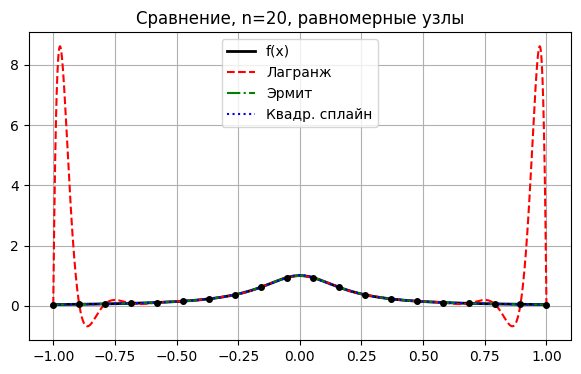

Lagrange         n= 6  err_emp=4.326923e-01  err_theory=None
HermiteCubic     n= 6  err_emp=2.500000e-01  err_theory=0.025600000000000032
QuadraticSpline  n= 6  err_emp=3.153846e-01  err_theory=0.06400000000000007
Lagrange         n=10  err_emp=3.002940e-01  err_theory=None
HermiteCubic     n=10  err_emp=5.562478e-02  err_theory=0.0024386526444139657
QuadraticSpline  n=10  err_emp=4.064928e-02  err_theory=0.01097393689986284
Lagrange         n=20  err_emp=8.578565e+00  err_theory=None
HermiteCubic     n=20  err_emp=4.194743e-03  err_theory=0.00012277376631548303
QuadraticSpline  n=20  err_emp=1.448748e-02  err_theory=0.0011663507799970876
Lagrange         n=40  err_emp=1.446459e+04  err_theory=None
HermiteCubic     n=40  err_emp=2.614936e-04  err_theory=6.916104625101764e-06
QuadraticSpline  n=40  err_emp=9.539679e-04  err_theory=0.00013486404018948428


In [6]:
# Запуск и графики

def plot_methods(x_nodes, title=''):    
    y_nodes = f(x_nodes)
    w = barycentric_weights(x_nodes)
    yL = lagrange_eval(x_nodes, y_nodes, X_test, w)
    H = build_hermite(x_nodes)
    yH = H.evaluate(X_test)
    QS = QuadraticSpline(x_nodes, y_nodes)
    yQ = QS.evaluate(X_test)

    plt.plot(X_test, Y_true, 'k-', lw=2, label='f(x)')
    plt.plot(X_test, yL, 'r--', label='Лагранж')
    plt.plot(X_test, yH, 'g-.', label='Эрмит')
    plt.plot(X_test, yQ, 'b:', label='Квадр. сплайн')
    plt.plot(x_nodes, y_nodes, 'ko', ms=4)
    plt.title(title)
    plt.legend(); plt.grid(True); plt.show()

n_demo = 20
x_demo = uniform_nodes(A, B, n_demo)
plot_methods(x_demo, title=f'Сравнение, n={n_demo}, равномерные узлы')

res = run_experiment(ns=(6, 10, 20, 40), nodes_kind='uniform')
for r in res:
    print(f"{r.name:16s} n={r.n:2d}  err_emp={r.err_emp:.6e}  err_theory={r.err_theory}")


## Вывод

- На равномерных узлах многочлен Лагранжа для функции Рунге демонстрирует эффект Рунге: рост погрешности и осцилляции на краях при увеличении n.
- Кубический эрмитов сплайн (с использованием f′) стабильно аппроксимирует f и даёт наименьшую фактическую ошибку среди рассмотренных методов; сходимость близка к O(h^4).
- Квадратичный сплайн даёт сглаженную аппроксимацию без осцилляций и ошибку порядка O(h^3), уступая эрмитовому, но заметно превосходя Лагранжа на равномерной сетке.
- Для практики на равномерной сетке предпочтительны сплайны; Лагранж уместен при специальных узлах  или малом числе узлов.
